In [1]:
import gc
import logging
logging.disable(logging.WARNING)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

2.6.3


In [2]:
# Load data
df = pd.read_parquet('E:/train_low_mem.parquet')
df.drop(['row_id'], inplace=True, axis=1)
investment_id = df.pop("investment_id")
y = df.pop("target")

investment_ids = list(investment_id.unique())
investment_id_lookup_layer = IntegerLookup(oov_token=-1, output_mode='int')
investment_id_lookup_layer.adapt(np.array(investment_ids))
vocab = investment_id_lookup_layer.get_vocabulary(include_special_tokens=True)
vocab_size = investment_id_lookup_layer.vocabulary_size()
print(max(investment_ids))
print(vocab_size)

3773
3580


In [3]:
def preprocess(x, y):
    # TODO
    return x, y

def make_dataset(feature, investment_id, y, batch_size=2048, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train": ds = ds.shuffle(8192, seed=69)  # only shuffle when training
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# Pearson correlation coefficient loss and metrics
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    return (1 - pearson_corr(y_true, y_pred, axis=axis)) + 2 * tf.keras.metrics.mean_squared_error(y_true, y_pred)

In [12]:
# Model
def build_model():
    investment_id_inputs = Input((1, ), name='inv_id_in', dtype=tf.uint16)
    features_inputs = Input((300, ), name='feature_in', dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(vocab_size, 64, input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)

    feature_x = GaussianNoise(0.01)(features_inputs)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)

    x = Concatenate(axis=1)([investment_id_x, feature_x])
    x = Dense(512, activation='swish', kernel_regularizer="l2")(x)
    # x = LayerNormalization()(x)
    # x = Dropout(0.2)(x)
    x = Dense(128, activation='swish', kernel_regularizer="l2")(x)
    # x = LayerNormalization()(x)
    # x = Dropout(0.2)(x)
    x = Dense(32, activation='swish', kernel_regularizer="l2")(x)
    # x = LayerNormalization()(x)
    # x = Dropout(0.2)(x)
    xOut = Dense(1, name='output')(x)

    model = Model(inputs=[investment_id_inputs, features_inputs], outputs=[xOut])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mse'])
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inv_id_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           inv_id_in[0][0]                  
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 64)        229120      integer_lookup[4][0]             
__________________________________________________________________________________________________
feature_in (InputLayer)         [(None, 300)]        0                                            
____________________________________________________________________________________________

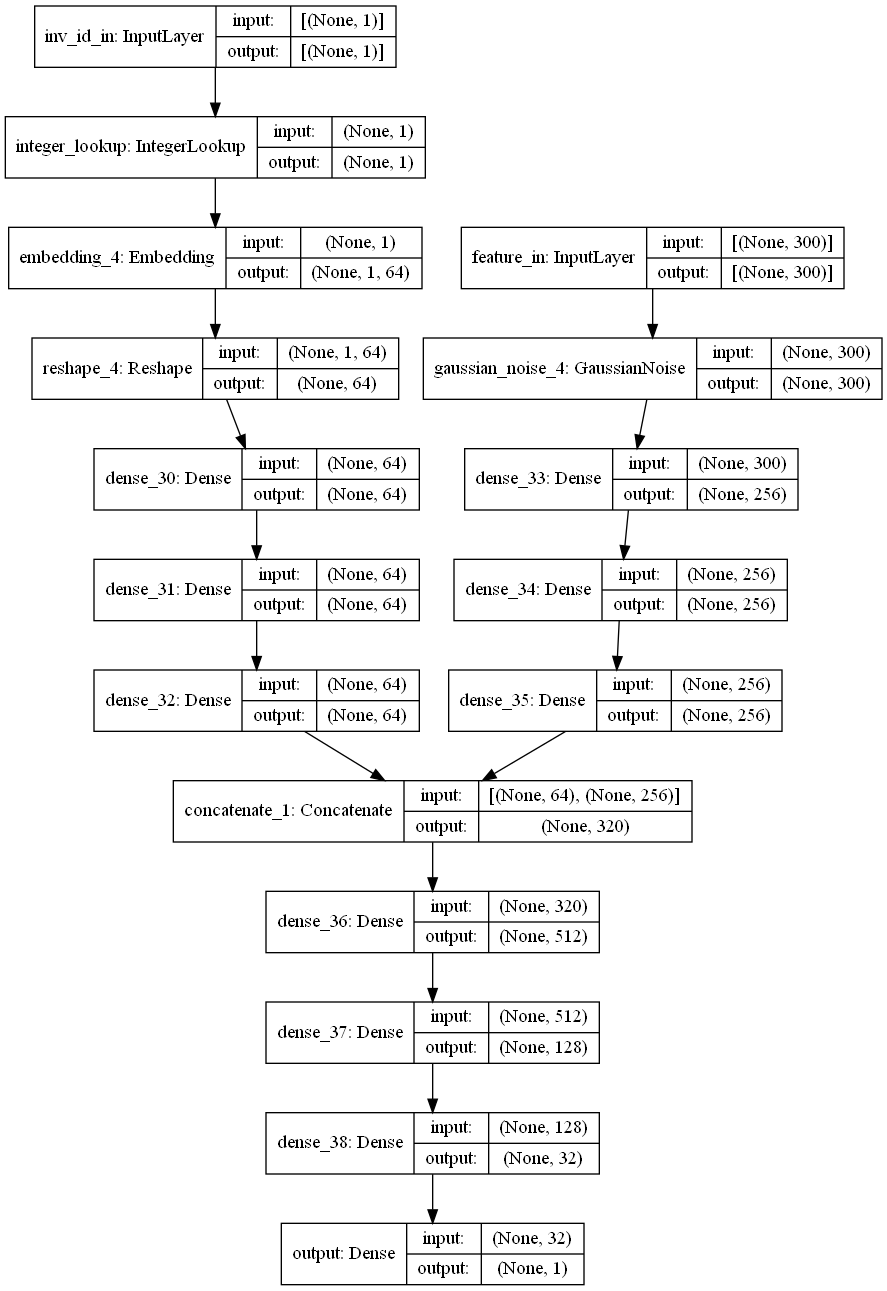

In [13]:
model = build_model()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [7]:
from typing import Tuple
import numpy as np

class GroupTimeSeriesSplit:
    """
    Custom class to create a Group Time Series Split. We ensure
    that the time id values that are in the testing data are not a part
    of the training data & the splits are temporal
    """
    def __init__(self, n_folds: int, holdout_size: int, groups: str) -> None:
        self.n_folds = n_folds
        self.holdout_size = holdout_size
        self.groups = groups

    def split(self, X) -> Tuple[np.array, np.array]:
        # Take the group column and get the unique values
        unique_time_ids = np.unique(self.groups.values)

        # Split the time ids into the length of the holdout size
        # and reverse so we work backwards in time. Also, makes
        # it easier to get the correct time_id values per
        # split
        array_split_time_ids = np.array_split(
            unique_time_ids, len(unique_time_ids) // self.holdout_size
        )[::-1]

        # Get the first n_folds values
        array_split_time_ids = array_split_time_ids[:self.n_folds]

        for time_ids in array_split_time_ids:
            # Get test index - time id values that are in the time_ids
            test_condition = X['time_id'].isin(time_ids)
            test_index = X.loc[test_condition].index

            # Get train index - The train index will be the time
            # id values right up until the minimum value in the test
            # data - we can also add a gap to this step by
            # time id < (min - gap)
            train_condition = X['time_id'] < (np.min(time_ids))
            train_index = X.loc[train_condition].index

            yield train_index, test_index

In [14]:
import scipy
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=69)
# group_time_series_split = GroupTimeSeriesSplit(n_folds=6, holdout_size=200, groups=df['time_id'])
models = []

for index, (train_indices, valid_indices) in enumerate(kfold.split(df, df['time_id'])):
    print(f'Model {index}')
    X_train, X_val = df.iloc[train_indices].loc[:, df.columns != 'time_id'], df.iloc[valid_indices].loc[:, df.columns != 'time_id']
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = build_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", monitor='val_mse', save_best_only=True, mode='min'),
                 tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min'),
                 tf.keras.callbacks.TerminateOnNaN()]
    history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}))

    pearson_score = scipy.stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

Model 0
Epoch 1/100
1279/1279 [==============================] - 12s 7ms/step - loss: 2.3256 - mse: 0.8320 - val_loss: 0.9254 - val_mse: 0.8444
Epoch 2/100
1279/1279 [==============================] - 8s 6ms/step - loss: 0.8544 - mse: 0.8295 - val_loss: 0.8473 - val_mse: 0.8430
Epoch 3/100
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8302 - mse: 0.8271 - val_loss: 0.8432 - val_mse: 0.8413
Epoch 4/100
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8276 - mse: 0.8254 - val_loss: 0.8422 - val_mse: 0.8405
Epoch 5/100
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8262 - mse: 0.8242 - val_loss: 0.8415 - val_mse: 0.8400
Epoch 6/100
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8251 - mse: 0.8233 - val_loss: 0.8411 - val_mse: 0.8396
Epoch 7/100
1279/1279 [==============================] - 6s 5ms/step - loss: 0.8242 - mse: 0.8224 - val_loss: 0.8407 - val_mse: 0.8393
Epoch 8/100
1279/1279 [=======================

In [17]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=2048):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)  # ensemble

models = [load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# models += [load_model(f"1/model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
test = pd.read_parquet('E:/train_low_mem.parquet')
time_ids = df['time_id'].unique()[-200:]
test = test.loc[test['time_id'].isin(time_ids)]  # take last 200 time id rows from df
# test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test)
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {iter_test.score()}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
            row_id    target
3137972     1219_0 -0.115540
3137973     1219_1 -0.126099
3137974     1219_2  0.009087
3137975     1219_3  0.198730
3137976     1219_4 -0.009567
...            ...       ...
3141405  1219_3768 -0.021988
3141406  1219_3769 -0.057220
3141407  1219_3770  0.096497
3141408  1219_3772  0.056793
3141409  1219_3773 -0.010315

[3438 rows x 2 columns]
Pearson: (           row_id    target  prediction
0          1020_0  0.523928    0.111755
1          1020_1  0.406231    0.111755
2          1020_2 -0.199893    0.159180
3          1020_3  2.121338    0.207275
4          1020_4 -0.516099    0.043701
...           ...       ...         ...
647417  1219_3768  0.033600   -0.021988
647418  1219_3769 -0.223264   -0.057220
647419  1219_3770 -0.559415    0.096497
647420  1219_3772  0.009599    0.056793
647421  1219_3773  1.212112   -0.010315

[647422 

In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

ModuleNotFoundError: No module named 'ubiquant'